# Transferability to PlanetScope

In [1]:
import sys

sys.path.append("..")
from model.segmentation_model import SegmentationModel
import torch
import numpy as np

import matplotlib.pyplot as plt

## Plastic Litter Project 2022

In [8]:
checkpoint_url = "https://marinedebrisdetector.s3.eu-central-1.amazonaws.com/models/unetpp_hrbands.ckpt"

import data.plastic_litter_project as plp
plp.download(".")
data_path = ".PLP"

!wget -nc {checkpoint_url}

# full model
checkpoint_url_full_model = "https://marinedebrisdetector.s3.eu-central-1.amazonaws.com/models/unet%2B%2B_durban.zip"
!wget -nc {checkpoint_url}
!unzip -n unet++_durban.zip

File ‘unetpp_hrbands.ckpt’ already there; not retrieving.

File ‘unetpp_hrbands.ckpt’ already there; not retrieving.

Archive:  unet++_durban.zip


## PlanetScope Predictions

<ipython-input-7-eeb29d4bd70f>:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3,1, figsize=(3,3*3))


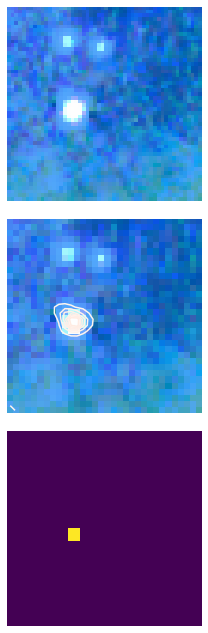

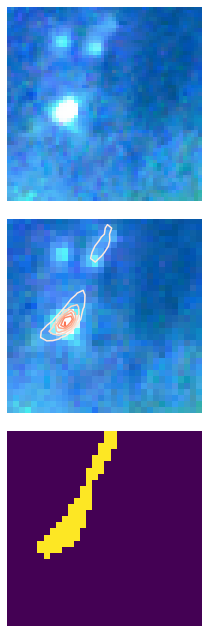

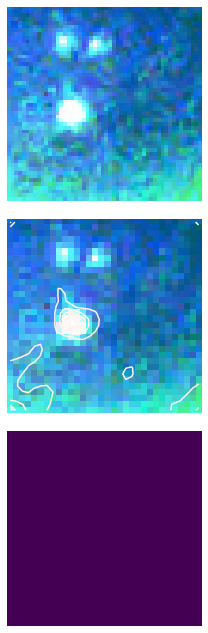

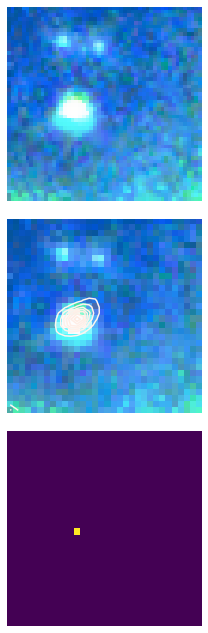

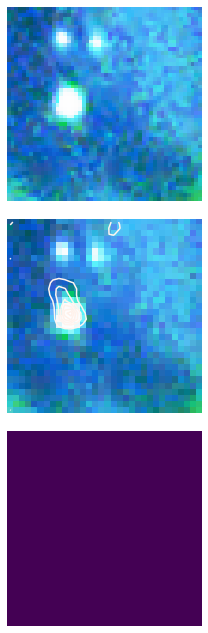

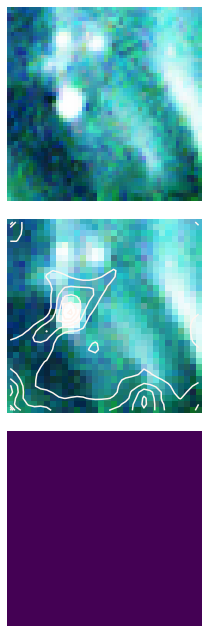

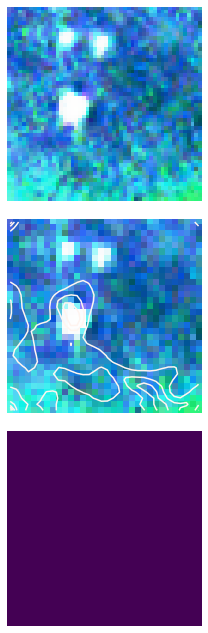

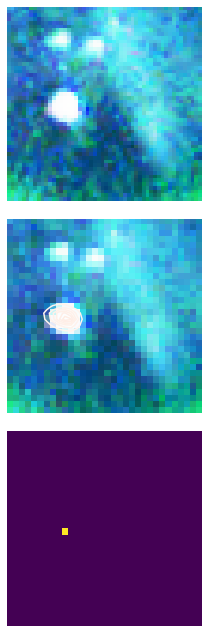

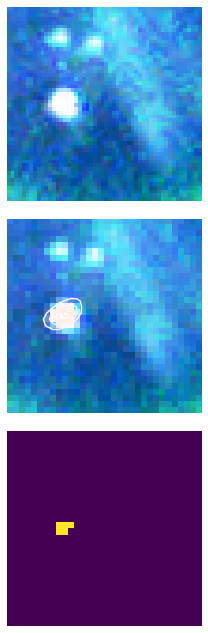

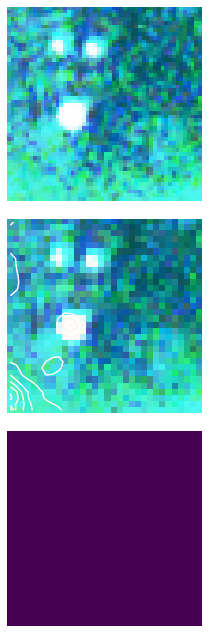

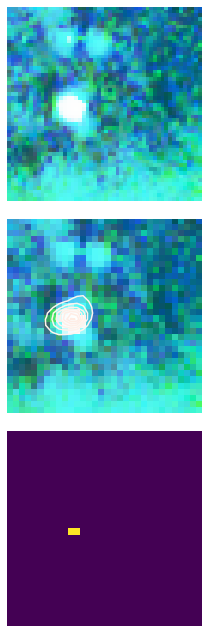

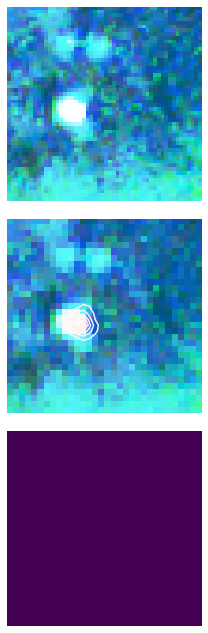

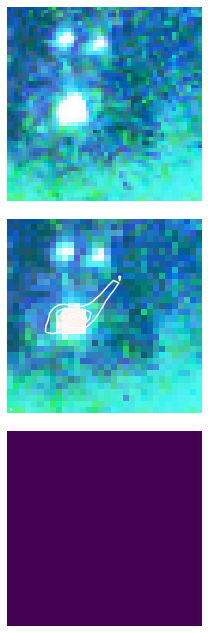

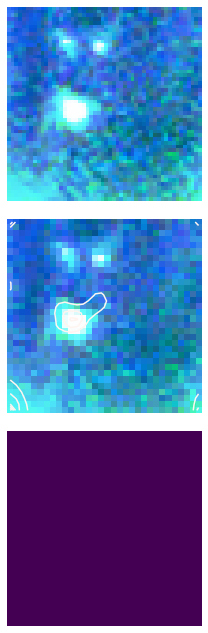

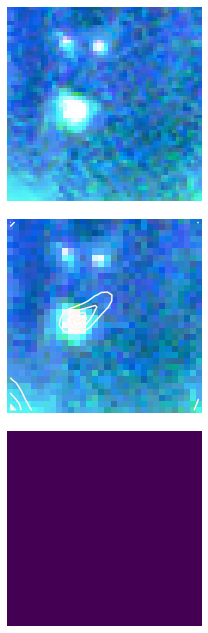

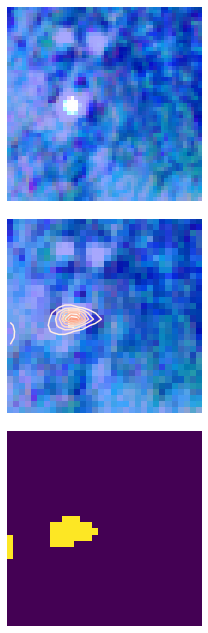

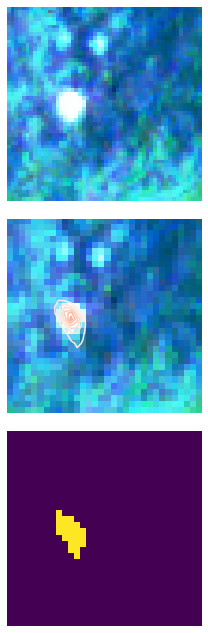

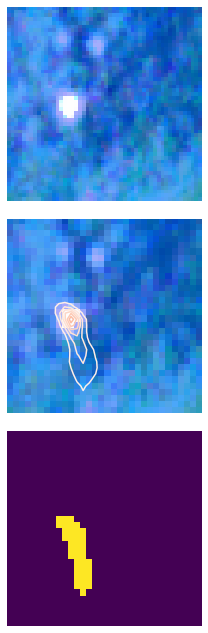

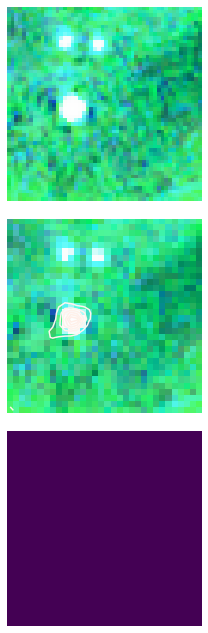

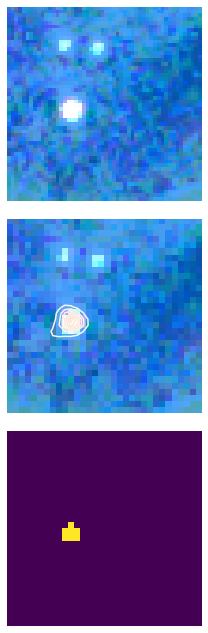

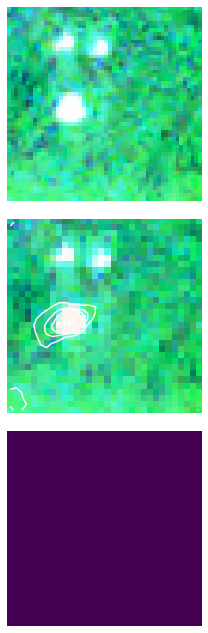

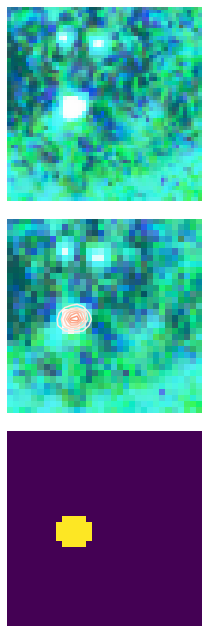

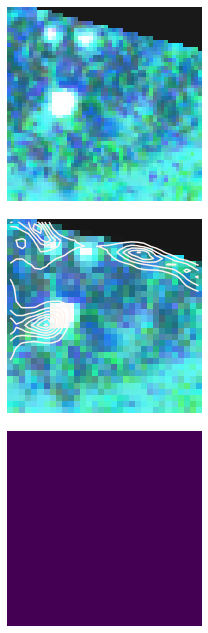

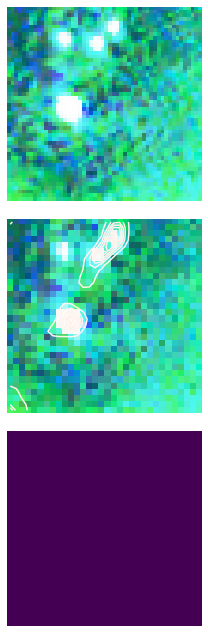

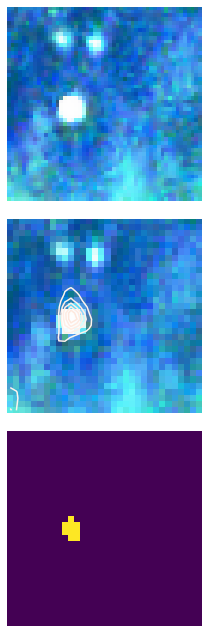

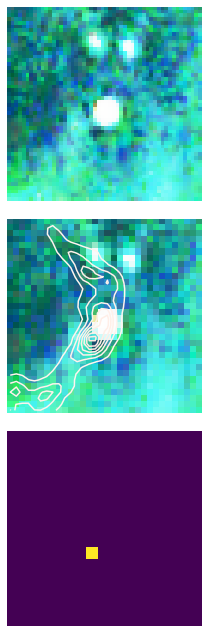

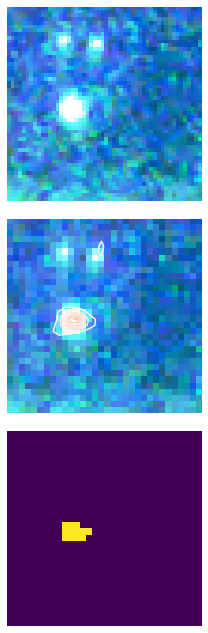

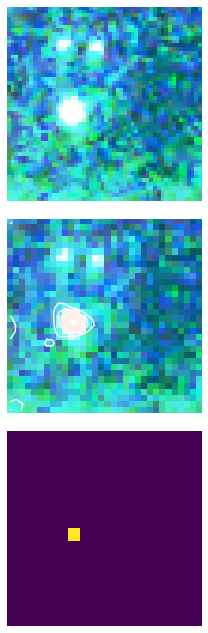

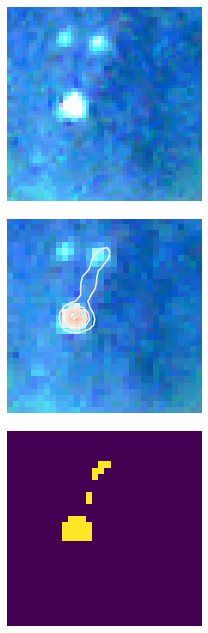

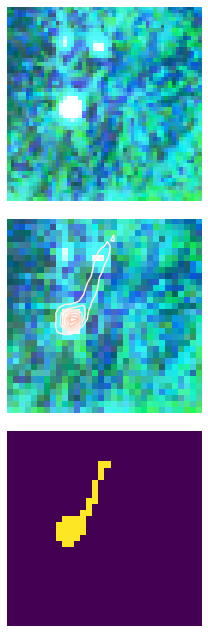

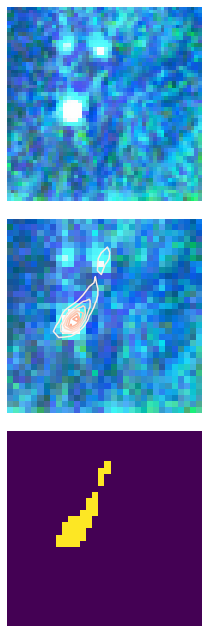

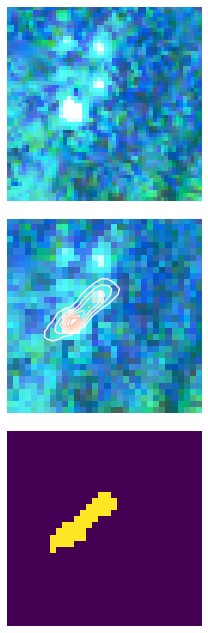

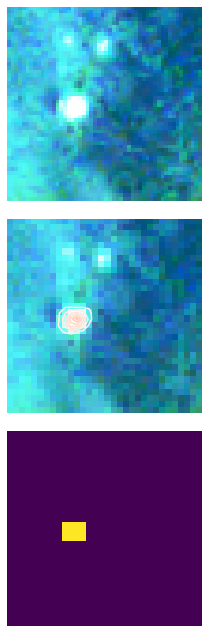

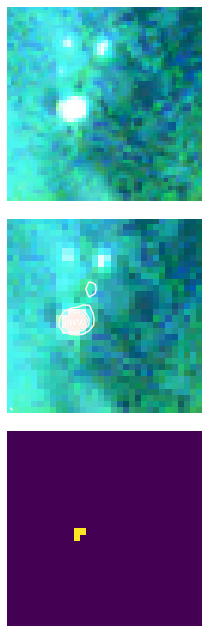

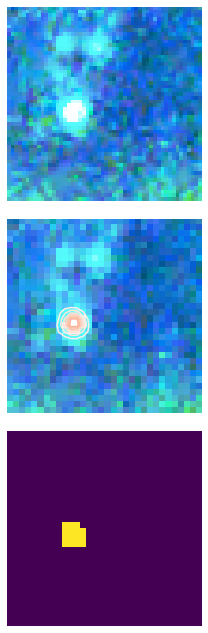

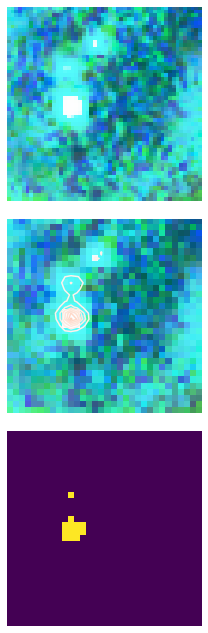

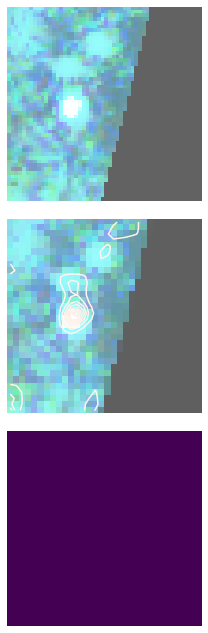

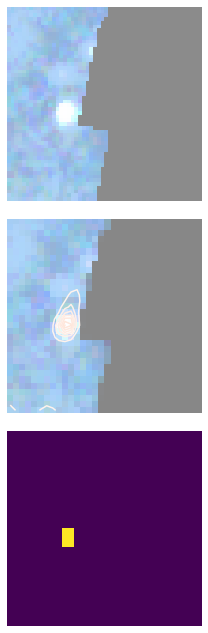

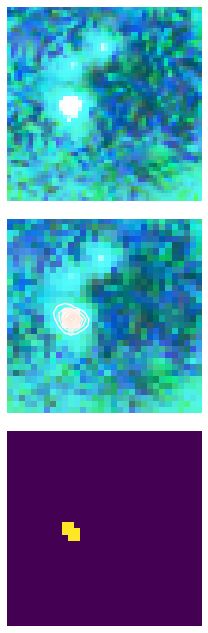

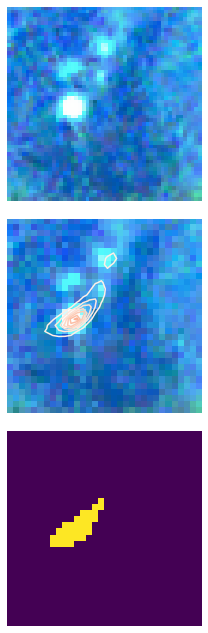

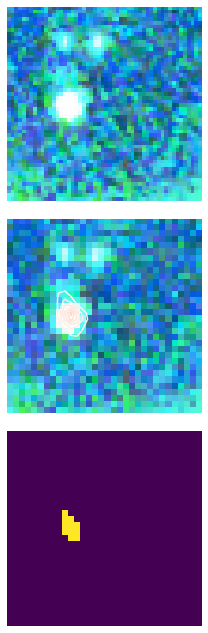

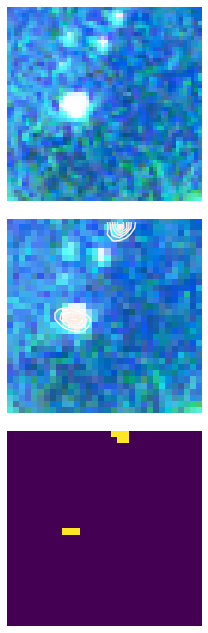

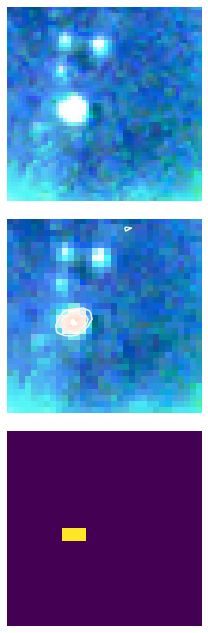

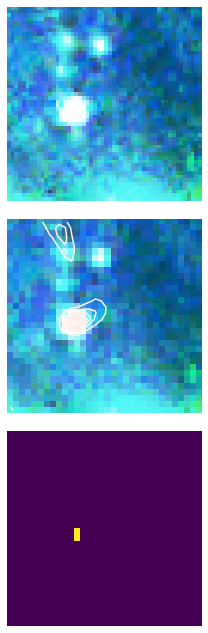

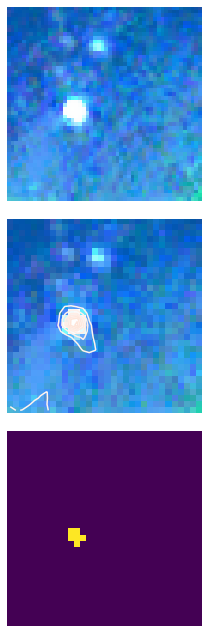

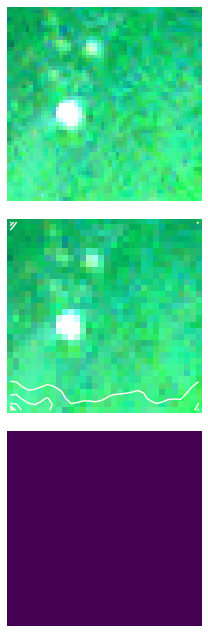

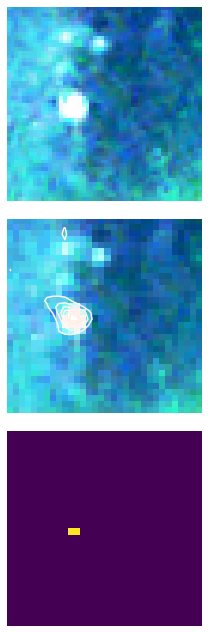

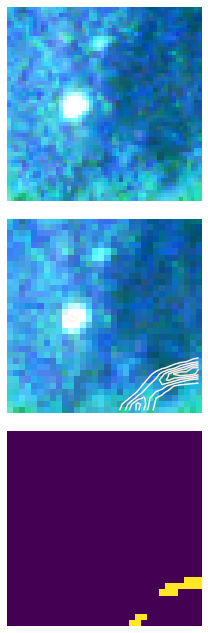

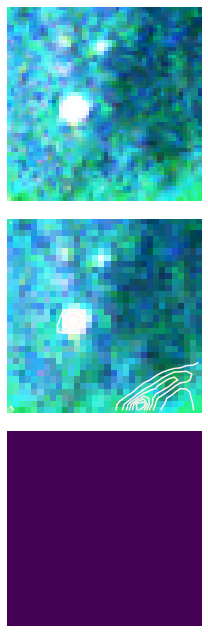

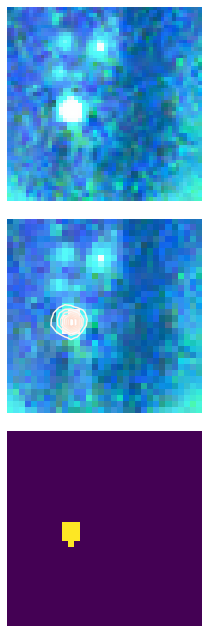

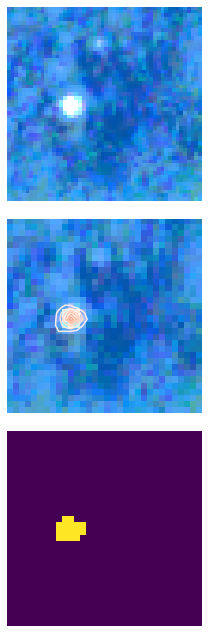

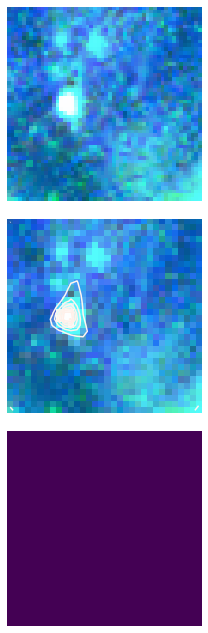

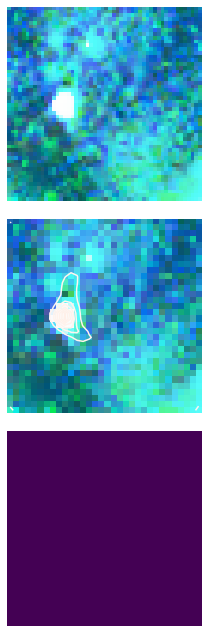

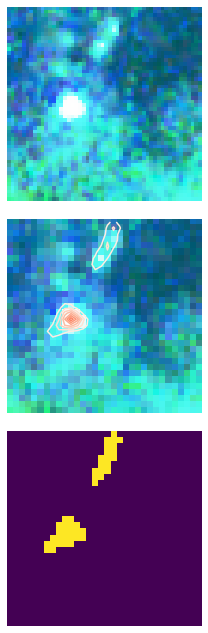

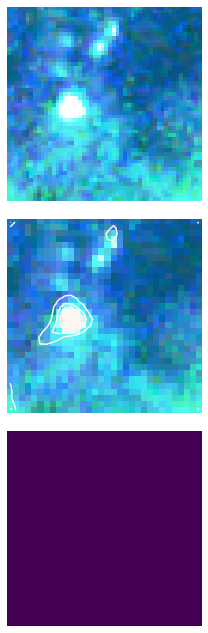

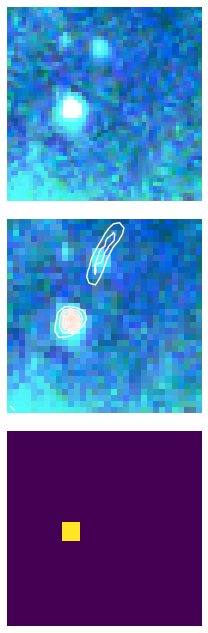

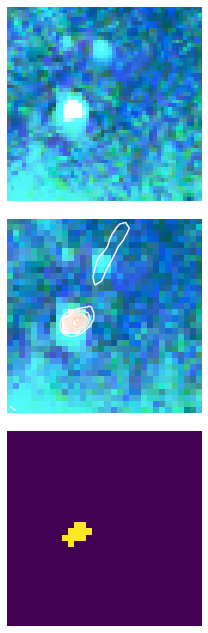

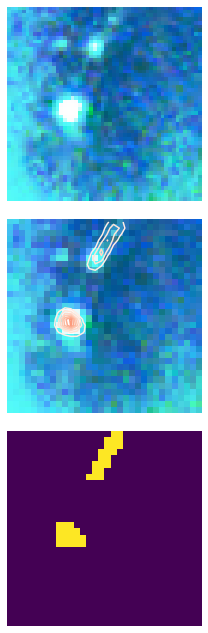

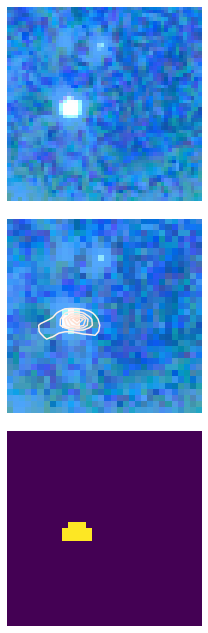

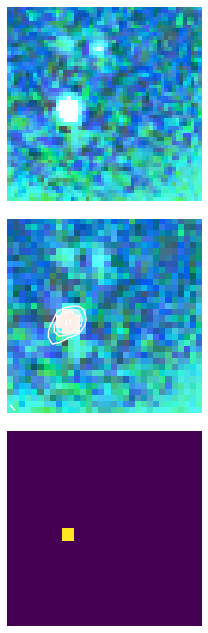

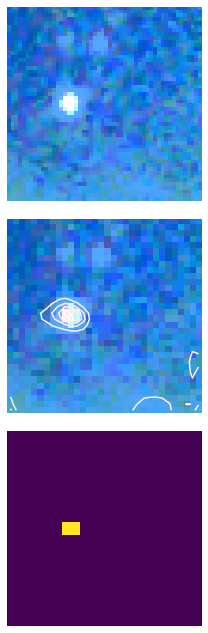

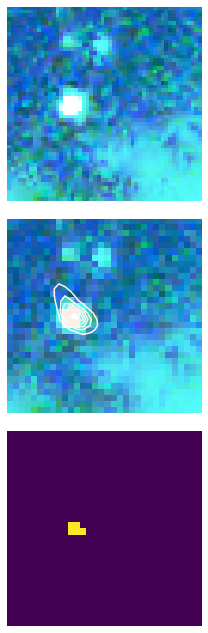

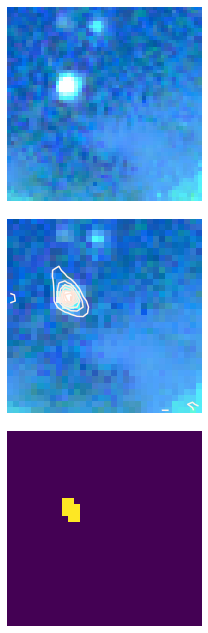

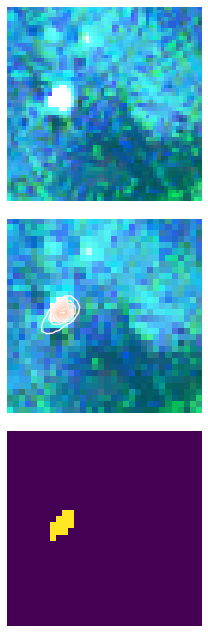

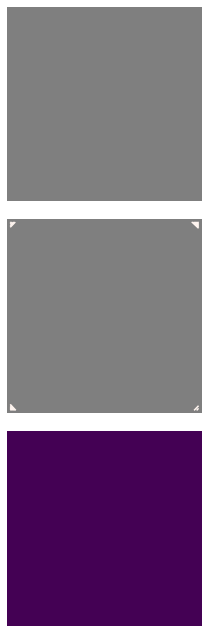

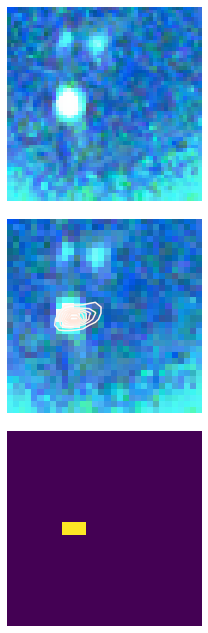

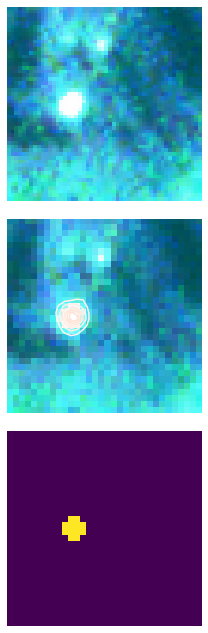

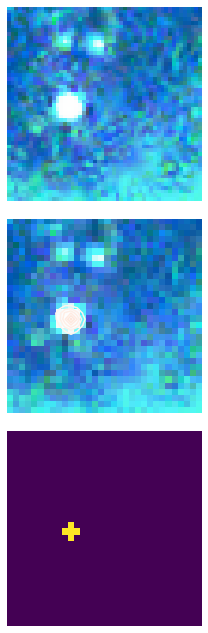

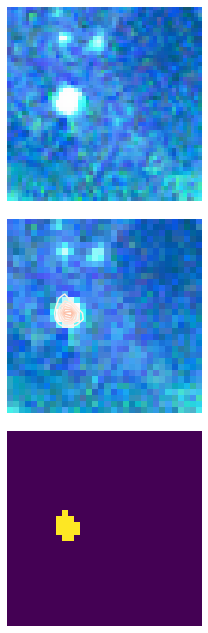

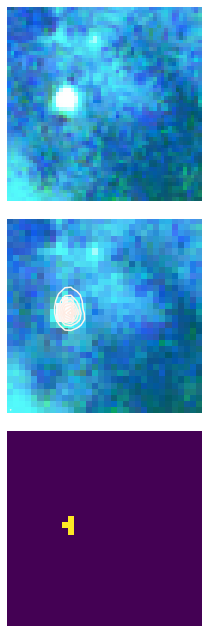

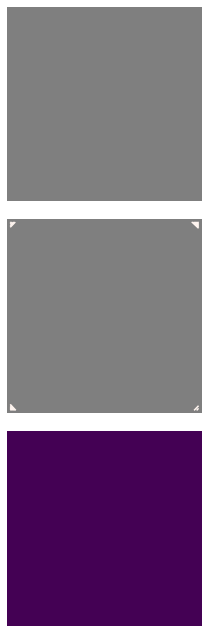

In [7]:
from data.plastic_litter_project import PlanetScopePLPDataset, ps_to_RGB, PLPDataset
from torchvision.transforms import Resize
import os

prediction_size = 32 # downsampled pixels sentinel resolution 10m
output_size = 53# in 3m pixels
resize = Resize(prediction_size)
resize_back = Resize(prediction_size)

planetds = PlanetScopePLPDataset(root=data_path, year=2022, output_size=output_size)

model = SegmentationModel.load_from_checkpoint("unetpp_hrbands.ckpt")
model.eval()

for image, mask, date in planetds:
    X = torch.from_numpy(image).float()# * 1e-4
    X = resize(X)
    y_score = torch.sigmoid(model(X.unsqueeze(0)))
    y_score = y_score.squeeze()

    hr_image = ps_to_RGB(image)

    downsampled_image = ps_to_RGB(X * 1e4)
    score_image = y_score.detach().numpy()
    classification = y_score > model.threshold

    fig, axs = plt.subplots(3,1, figsize=(3,3*3))
    ax = axs[0]
    ax.imshow(hr_image)
    ax.axis("off")

    ax = axs[1]
    ax.imshow(downsampled_image)
    ax.contour(score_image, vmin=0, vmax=1, cmap="Reds")
    ax.axis("off")

    ax = axs[2]
    ax.imshow(classification)
    ax.axis("off")


    plt.tight_layout()
    os.makedirs("/tmp/plp2022/",exist_ok=True)
    fig.savefig(f"/tmp/plp2022/ps-{date}.png", transparent=True, bbox_inches="tight", pad_inches=0)


### Sentinel-2 predictions

/home/marc/anaconda3/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
<ipython-input-42-82d8ceea870d>:20: UserWarning: The following kwargs were not used by contour: 'map'
  ax.contour(y_score.detach().numpy()[8:-8, 8:-8], vmin=0, vmax=1, map="Reds")
/home/marc/anaconda3/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)
<ipython-input-42-82d8ceea870d>:20: UserWarning: The following kwargs were not used by contour: 'map'
  ax.contour(y_score.detach().numpy()[8:-8, 8:-8], vmin=0, vmax=1, map="Reds")
/home/marc/anaconda3/lib/python3.8/site-packages/skimage/_shared

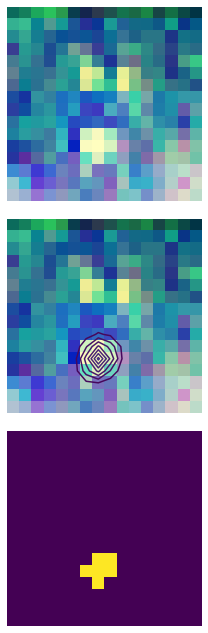

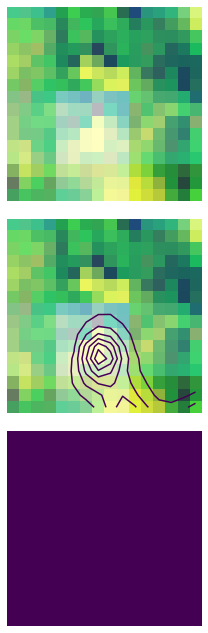

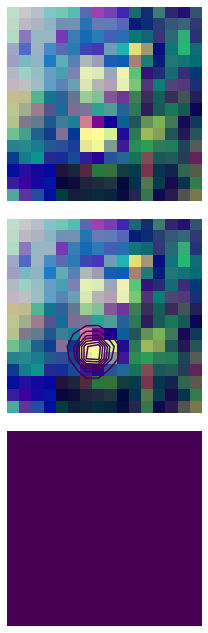

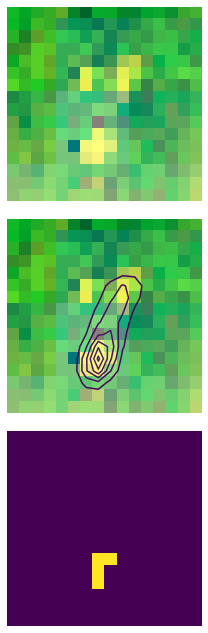

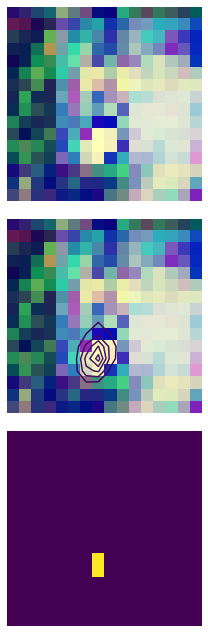

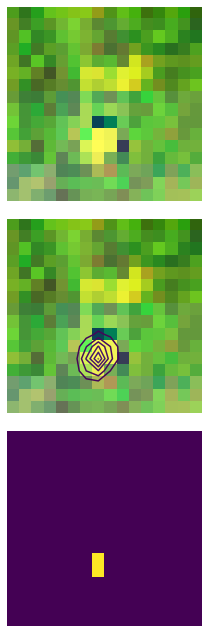

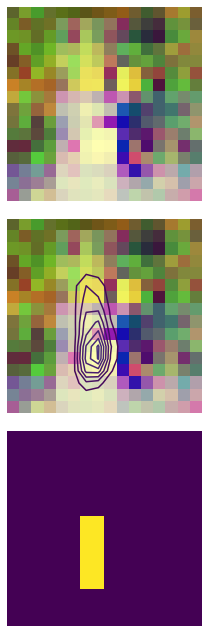

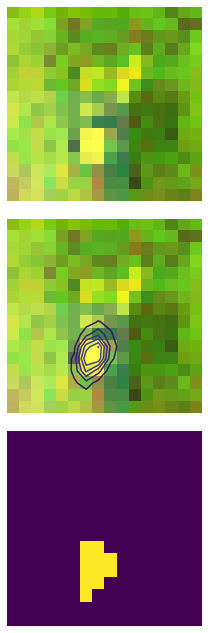

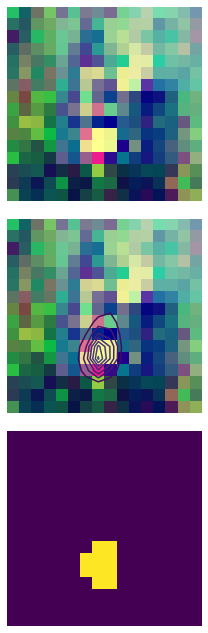

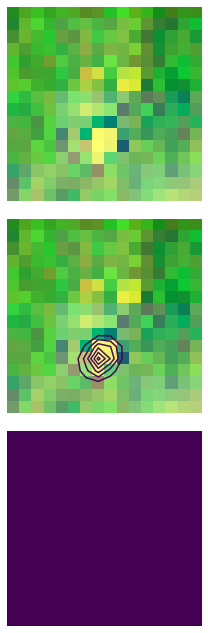

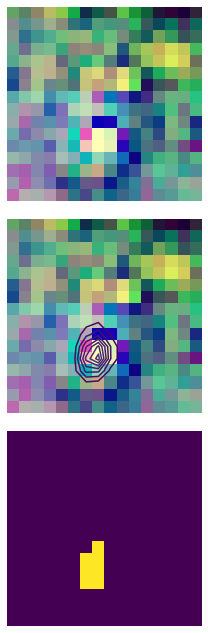

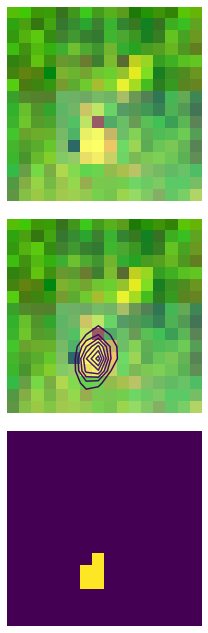

In [42]:
full_model = SegmentationModel.load_from_checkpoint("unet++_durban/epoch=89-val_loss=0.52.ckpt")

#full_model = SegmentationModel.load_from_checkpoint("/home/marc/projects/marinedetector/checkpoints/flobs-segm-hrbands/flobs-segm-allbands/epoch=92-val_loss=0.51.ckpt")
full_model.eval()

ds = PLPDataset(root="/data/marinedebris/PLP", year=2022, output_size=32)

for image, mask, date in ds:
    X = torch.from_numpy(image)
    y_score = torch.sigmoid(full_model.model(X.unsqueeze(0)))
    y_score = y_score.squeeze()

    fig, axs = plt.subplots(3, 1, figsize=(3,3*3))
    ax = axs[0]
    ax.imshow(ps_to_RGB(image * 1e4)[8:-8, 8:-8])
    ax.axis("off")

    ax = axs[1]
    ax.imshow(ps_to_RGB(X * 1e4)[8:-8, 8:-8])
    ax.contour(y_score.detach().numpy()[8:-8, 8:-8], vmin=0, vmax=1, map="Reds")
    ax.axis("off")

    ax = axs[2]
    ax.imshow((y_score > model.threshold)[8:-8, 8:-8])
    ax.axis("off")

    plt.tight_layout()
    os.makedirs("/tmp/plp2022/",exist_ok=True)
    fig.savefig(f"/tmp/plp2022/s2-{date}.png", transparent=True, bbox_inches="tight", pad_inches=0)

## Qualitative Prediction Accra

In [35]:
!wget -nc https://marinedebrisdetector.s3.eu-central-1.amazonaws.com/data/planetscope_accra_qualitative.zip
!unzip -n planetscope_accra_qualitative.zip

point_file = "planetscope_accra_qualitative/accra_20181031_qualitative_point.shp"
s2scene = "planetscope_accra_qualitative/accra_20181031.tif"
ps_scene = "planetscope_accra_qualitative/20181031_101439_0f36_3B_AnalyticMS_SR.tif"

File ‘planetscope_accra_qualitative.zip’ already there; not retrieving.

Archive:  planetscope_accra_qualitative.zip


In [36]:
import geopandas as gpd
import rasterio as rio
from visualization import rgb
from rasterio.windows import from_bounds
from data.utils import read_tif_image

gdf = gpd.read_file(point_file)

(-0.5, 127.5, 127.5, -0.5)

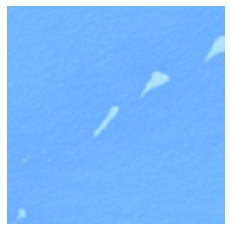

In [43]:

offset = 640

with rio.open(s2scene) as src:
    crs = src.crs
    transform = src.transform

gdf_ = gdf.to_crs(crs)
x = gdf_.iloc[0].geometry.centroid.x
y = gdf_.iloc[0].geometry.centroid.y

window = from_bounds(x-offset,y-offset,x+offset,y+offset,transform)
s2_arr, transform = read_tif_image(s2scene,window)

#plt.imshow(rgb(s2_arr).transpose(1,2,0))
s2_rgb = np.clip(s2_arr[np.array([3,2,1])] / 1000,0,1).transpose(1,2,0)

fig, ax = plt.subplots()
ax.imshow(s2_rgb)
ax.axis("off")

(-0.5, 127.5, 127.5, -0.5)

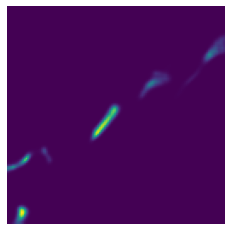

In [44]:
X = torch.from_numpy(s2_arr * 1e-4).float()

y_score = torch.sigmoid(full_model.model(X.unsqueeze(0)))
y_score = y_score.squeeze()

fig, ax = plt.subplots()
ax.imshow(y_score.detach().numpy())
ax.axis("off")

In [45]:
with rio.open(ps_scene) as src:
    crs = src.crs
    transform = src.transform

offset = 640

gdf_ = gdf.to_crs(crs)
x = gdf_.iloc[0].geometry.centroid.x
y = gdf_.iloc[0].geometry.centroid.y
window = from_bounds(x-offset,y-offset,x+offset,y+offset,transform)

window = from_bounds(x-offset,y-offset,x+offset,y+offset,src.transform)
with rio.open(ps_scene) as src:
    ps_arr = src.read(window=window)

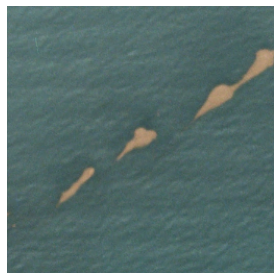

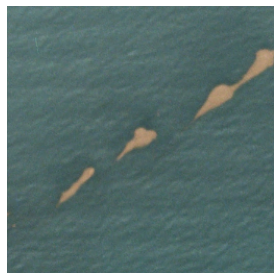

In [46]:
from skimage.exposure import equalize_hist
#ps_rgb = equalize_hist(ps_arr[np.array([2,1,0])]).transpose(1,2,0)

from torchvision.transforms import Resize
resize = Resize(256)

ps_arr_downsample = resize(torch.from_numpy(ps_arr.astype(np.int16))).numpy()
ps_rgb_downsample = np.clip(ps_arr_downsample[np.array([2,1,0])] / 1000,0,1).transpose(1,2,0)

ps_rgb = np.clip(ps_arr[np.array([2,1,0])] / 1000,0,1).transpose(1,2,0)

fig, ax = plt.subplots()
ax.imshow(ps_rgb_downsample)
ax.axis("off")

plt.tight_layout()


fig, ax = plt.subplots()
ax.imshow(ps_rgb_downsample)
ax.axis("off")

plt.tight_layout()

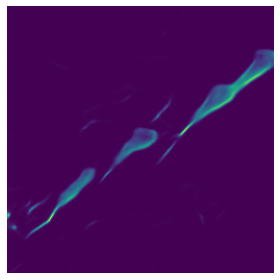

In [47]:

X = torch.from_numpy(ps_arr * 1e-4).float()

X = resize(X)

y_score = torch.sigmoid(model.model(X.unsqueeze(0)))
y_score = y_score.squeeze().detach().numpy()

fig, ax = plt.subplots()

ax.imshow(ps_rgb_downsample)
ax.imshow(y_score)
ax.axis("off")

plt.tight_layout()